In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=47becaf165380ec99304679ced4d9183bce325cec5d4d8d0711e10b89e21f733
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install --upgrade scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


In [ ]:
!pip install --upgrade numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 32.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2


In [ ]:
!pip uninstall scipy
!pip install scipy


Found existing installation: scipy 1.13.0
Uninstalling scipy-1.13.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scipy-1.13.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-24bff013.3.26.dev.so
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/scipy/*
Proceed (Y/n)? Y
  Successfully uninstalled scipy-1.13.0
  Using cached scipy-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)


In [ ]:
!pip install scipy==1.7.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.0
    Uninstalling scipy-1.13.0:
      Successfully uninstalled scipy-1.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires scipy>=1.8.0, but you have scipy 1.7.3 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.22.4 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 1.22.4 which is incompatible.
jax 0.4.26 requires scipy>=1.9, but you have scipy 1.7.3 which is incompatible.
jaxlib 0.4.26+cuda

In [ ]:
import os
import numpy as np
import librosa
from scipy.fft import fft
import librosa.display
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lime import lime_tabular

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
DATADIR = '/content/drive/MyDrive/fan/id_00'
CATEGORIES = ['abnormal', 'normal']

In [ ]:
# Function to calculate zero crossing rate
def zero_crossing_rate(audio_array):
    return len(np.where(np.diff(np.sign(audio_array)))[0])

# Create an empty list to store the training data
training_data = []

In [ ]:
# Loop through each category
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)

    # Loop through each audio file in the category
    for audio in os.listdir(path):
        audio_path = os.path.join(path, audio)
        audio_array, sr_array = librosa.load(audio_path, duration=30)  # Load audio

        # Extract time domain features
        mean = np.mean(audio_array)
        median = np.median(audio_array)
        variance = np.var(audio_array)
        std_dev = np.std(audio_array)
        skewness = skew(audio_array)
        kurt = kurtosis(audio_array)
        zero_cross_rate_value = zero_crossing_rate(audio_array)

        # Additional features
        peaks, _ = find_peaks(audio_array)
        num_waves = len(peaks)
        wave_duration = len(audio_array) / (num_waves + 1)  # Assuming one wave between each peak

        # Estimate pitch using harmonic and pitch_tuning functions
        harmonic, percussive = librosa.effects.hpss(audio_array)
        pitches, magnitudes = librosa.core.piptrack(y=harmonic, sr=sr_array)
        pitches = pitches[magnitudes > np.median(magnitudes)]

        if len(pitches) > 0:
          inst_freq = np.mean(librosa.hz_to_midi(pitches))
        else:
          inst_freq = 0.0  # Default value if no pitch is detected

        hjorth_params = librosa.feature.mfcc(y=audio_array, sr=sr_array, n_mfcc=13)
        mobility = np.mean(hjorth_params[1, :]) / np.mean(hjorth_params[0, :])
        activity = np.mean(hjorth_params[1, :])
        complexity = np.mean(hjorth_params[2, :])

        k_complex = np.sum(np.abs(np.diff(audio_array)) > 0.5)  # Example threshold

        energy = np.sum(audio_array**2)

        # Extract frequency domain features
        fft_result = fft(audio_array)
        freq_domain = np.abs(fft_result[:len(fft_result)//2])

        mean_freq = np.mean(freq_domain)
        median_freq = np.median(freq_domain)
        variance_freq = np.var(freq_domain)
        std_dev_freq = np.std(freq_domain)
        skewness_freq = skew(freq_domain)
        kurt_freq = kurtosis(freq_domain)

        # Additional frequency domain features
        delta = np.sum(freq_domain[(0 <= freq_domain) & (freq_domain <= 4)])
        theta = np.sum(freq_domain[(4 < freq_domain) & (freq_domain <= 8)])
        alpha = np.sum(freq_domain[(8 < freq_domain) & (freq_domain <= 13)])
        beta = np.sum(freq_domain[(13 < freq_domain) & (freq_domain <= 30)])
        gamma = np.sum(freq_domain[(30 < freq_domain) & (freq_domain <= 40)])
        sigma = np.sum(freq_domain[(40 < freq_domain) & (freq_domain <= 50)])

        zero_a = np.sum(freq_domain[(0 < freq_domain) & (freq_domain <= alpha)])
        b_a = np.sum(freq_domain[(beta < freq_domain) & (freq_domain <= alpha)])

        features = [mean, median, variance, std_dev, skewness, kurt,
                    zero_cross_rate_value, num_waves, wave_duration,inst_freq,
                    mobility, activity, complexity, k_complex, energy,
                    mean_freq, median_freq, variance_freq, std_dev_freq, skewness_freq, kurt_freq,
                    delta, theta, alpha, beta, gamma, sigma, zero_a, b_a]

        # Append the features and class number to the training data list
        training_data.append([features, class_num])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [ ]:
# Separate features and class labels
X = [features[0] for features in training_data]
y = [class_num for _, class_num in training_data]

# Ensure all feature vectors have the same length
max_length = max(len(features) for features in X)
X_flat = [np.pad(features, (0, max_length - len(features))) for features in X]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Train a Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Create an array of different values for num_features_to_select
num_features_to_select_values = [3, 4, 5, 6, 7 , 8, 9]

# Dictionary to store results
results = {}

for num_features_to_select in num_features_to_select_values:
    # Feature selection using RFE
    rfe = RFE(estimator=lr_model, n_features_to_select=num_features_to_select)
    X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
    X_test_rfe = rfe.transform(X_test_scaled)

    # Train Logistic Regression with selected features
    lr_model_rfe = LogisticRegression()
    lr_model_rfe.fit(X_train_rfe, y_train)

    # Evaluate Logistic Regression with selected features
    y_pred_lr = lr_model_rfe.predict(X_test_rfe)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)

    # Store results
    results[num_features_to_select] = {
        'model': lr_model_rfe,
        'accuracy': accuracy_lr
    }

# Print results
for num_features, result in results.items():
    print(f"\nNumber of Features Selected: {num_features}")
    print(f"Accuracy: {result['accuracy']}")


Number of Features Selected: 3
Accuracy: 0.7992957746478874

Number of Features Selected: 4
Accuracy: 0.795774647887324

Number of Features Selected: 5
Accuracy: 0.7922535211267606

Number of Features Selected: 6
Accuracy: 0.795774647887324

Number of Features Selected: 7
Accuracy: 0.795774647887324

Number of Features Selected: 8
Accuracy: 0.7922535211267606

Number of Features Selected: 9
Accuracy: 0.7887323943661971


In [ ]:
# Train Logistic Regression with selected features
lr_model_rfe = LogisticRegression()
lr_model_rfe.fit(X_train_rfe, y_train)

LogisticRegression()

In [ ]:
pip install pandas scipy scikit-learn shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.9 MB/s eta 0:00:00


ExactExplainer explainer: 285it [00:17, 16.44it/s]


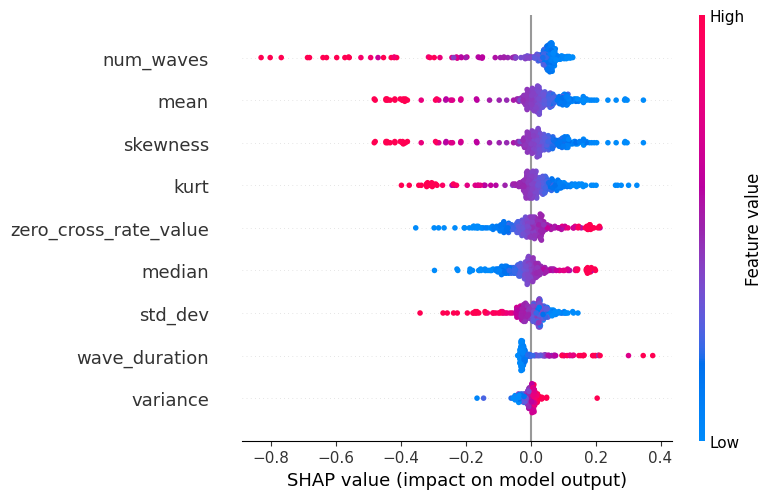

In [ ]:
import shap

# Assuming X has feature names (replace 'feature_1', 'feature_2', etc. with your actual feature names)
feature_names = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurt',
                 'zero_cross_rate_value', 'num_waves', 'wave_duration','inst_freq',
                 'mobility', 'activity', 'complexity', 'k_complex', 'energy',
                 'mean_freq', 'median_freq', 'variance_freq', 'std_dev_freq', 'skewness_freq', 'kurt_freq',
                 'delta, theta', 'alpha', 'beta', 'gamma', 'sigma', 'zero_a', 'b_a']

# Train Logistic Regression with selected features
lr_model_rfe = LogisticRegression()
lr_model_rfe.fit(X_train_rfe, y_train)

# SHAP explanation
explainer = shap.Explainer(lr_model_rfe.predict, X_train_rfe)
shap_values = explainer(X_test_rfe)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_rfe, feature_names=feature_names)


Accuracy: 0.795774647887324


ExactExplainer explainer: 285it [03:44,  1.25it/s]


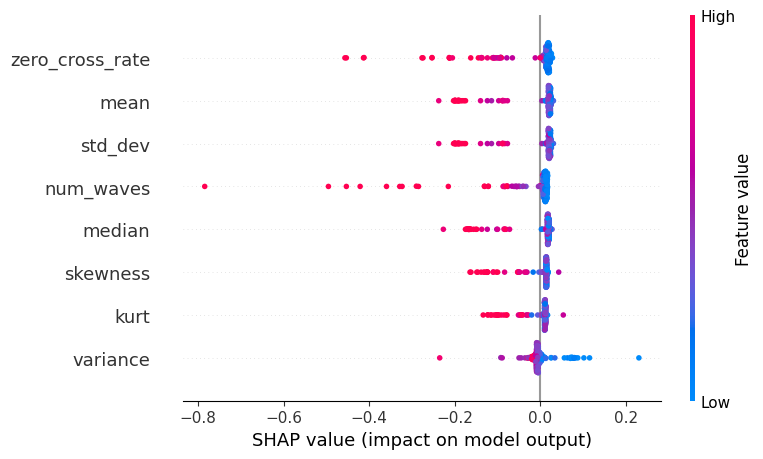

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an SVC model
svc_model = SVC(kernel='linear')
svc_model.fit(X_train_scaled, y_train)

# Wrap SVC model in SelectFromModel
sfm = SelectFromModel(estimator=svc_model, max_features=10)  # You can adjust max_features as needed
X_train_sfm = sfm.fit_transform(X_train_scaled, y_train)
X_test_sfm = sfm.transform(X_test_scaled)

# Feature selection using RFE
rfe = RFE(estimator=svc_model, n_features_to_select=10)  # You can adjust n_features_to_select as needed
X_train_rfe = rfe.fit_transform(X_train_sfm, y_train)
X_test_rfe = rfe.transform(X_test_sfm)

# Train SVC with selected features
svc_model_rfe = SVC()
svc_model_rfe.fit(X_train_rfe, y_train)

# Evaluate SVC with selected features
y_pred_svc = svc_model_rfe.predict(X_test_rfe)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy: {accuracy_svc}")

# SHAP explanation
explainer = shap.Explainer(svc_model_rfe.predict, X_train_rfe)
shap_values = explainer(X_test_rfe)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_rfe, feature_names=feature_names)


Accuracy: 0.8345070422535211


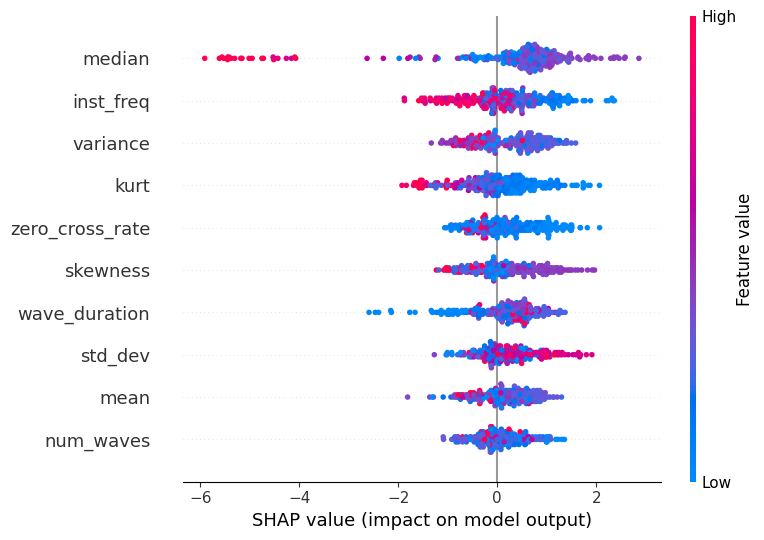

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)

# Feature selection using RFE
rfe = RFE(estimator=xgb_model, n_features_to_select=10)  # You can adjust n_features_to_select as needed
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Train XGBoost with selected features
xgb_model_rfe = XGBClassifier()
xgb_model_rfe.fit(X_train_rfe, y_train)

# Evaluate XGBoost with selected features
y_pred_xgb = xgb_model_rfe.predict(X_test_rfe)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy_xgb}")

# SHAP explanation
explainer = shap.Explainer(xgb_model_rfe)
shap_values = explainer(X_test_rfe)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_rfe, feature_names=feature_names)


Accuracy: 0.8274647887323944


ExactExplainer explainer: 285it [04:14,  1.08it/s]


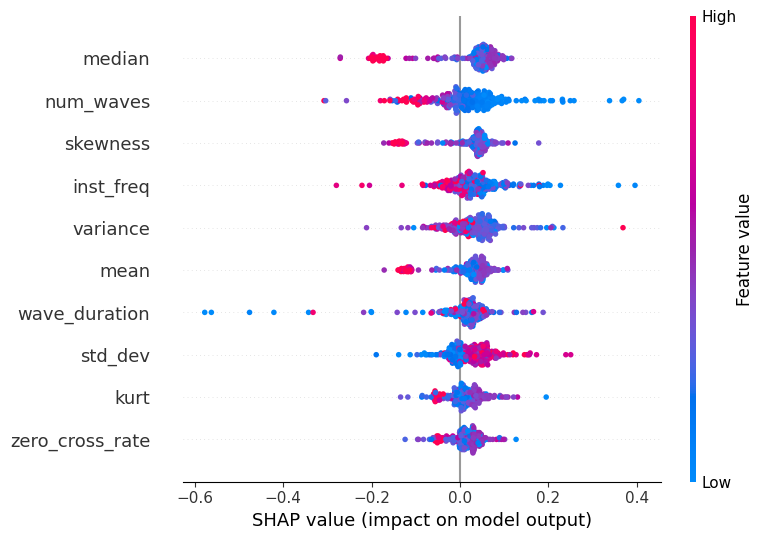

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

# Feature selection using RFE
rfe = RFE(estimator=rf_model, n_features_to_select=10)  # You can adjust n_features_to_select as needed
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Train Random Forest with selected features
rf_model_rfe = RandomForestClassifier()
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate Random Forest with selected features
y_pred_rf = rf_model_rfe.predict(X_test_rfe)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

# SHAP explanation
explainer = shap.Explainer(rf_model_rfe.predict, X_train_rfe)
shap_values = explainer(X_test_rfe)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_rfe, feature_names=feature_names)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Models
models = {
    'XGBoost': XGBClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    confusion_mat = confusion_matrix(y_test, predictions)

    # Output
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{confusion_mat}")



XGBoost Results:
Accuracy: 0.8133802816901409
F1 Score: 0.7924822433472164
Precision: 0.8172364302577018
Recall: 0.8133802816901409
Confusion Matrix:
[[ 36  46]
 [  7 195]]

SVC Results:
Accuracy: 0.7147887323943662
F1 Score: 0.5994359899303909
Precision: 0.7964216393768975
Recall: 0.7147887323943662
Confusion Matrix:
[[  1  81]
 [  0 202]]

GaussianNB Results:
Accuracy: 0.7922535211267606
F1 Score: 0.761351591650458
Precision: 0.7991087084757541
Recall: 0.7922535211267606
Confusion Matrix:
[[ 29  53]
 [  6 196]]

Random Forest Results:
Accuracy: 0.8133802816901409
F1 Score: 0.7874468084545527
Precision: 0.8276840163422817
Recall: 0.8133802816901409
Confusion Matrix:
[[ 33  49]
 [  4 198]]


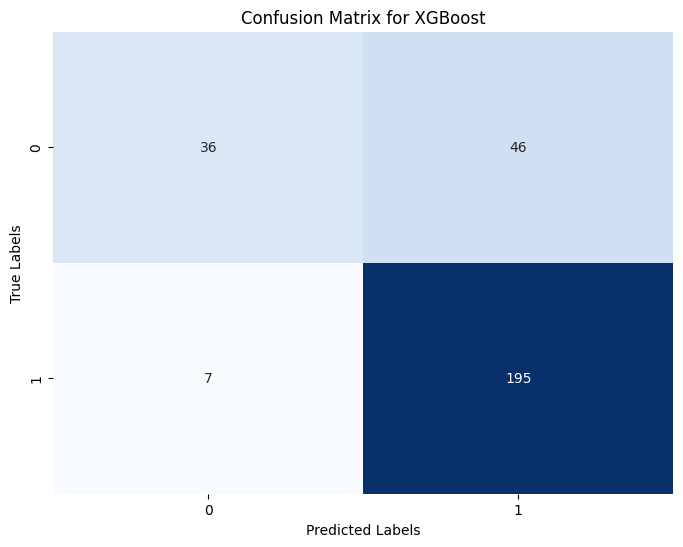


XGBoost Results:
Accuracy: 0.8133802816901409
F1 Score: 0.7924822433472164
Precision: 0.8172364302577018
Recall: 0.8133802816901409


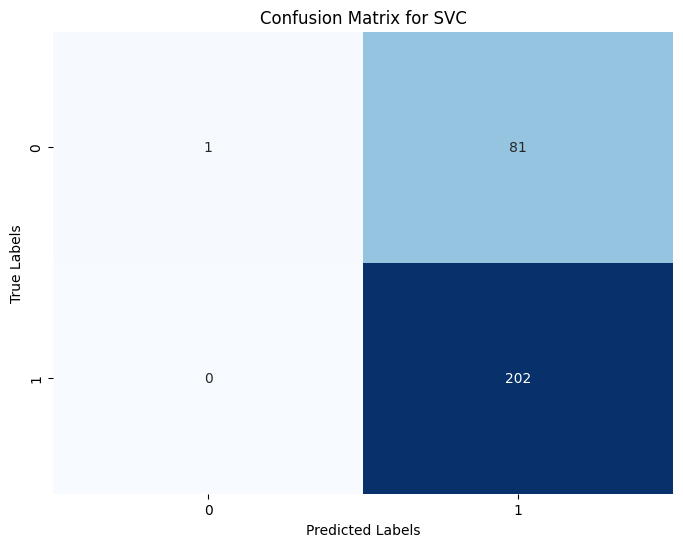


SVC Results:
Accuracy: 0.7147887323943662
F1 Score: 0.5994359899303909
Precision: 0.7964216393768975
Recall: 0.7147887323943662


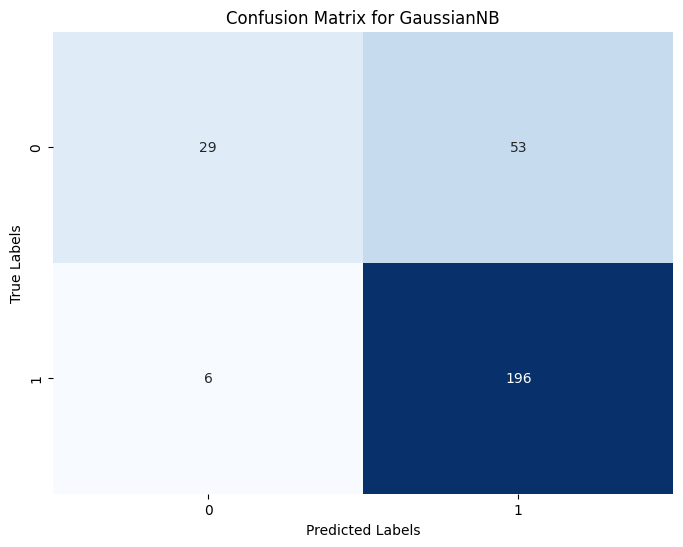


GaussianNB Results:
Accuracy: 0.7922535211267606
F1 Score: 0.761351591650458
Precision: 0.7991087084757541
Recall: 0.7922535211267606


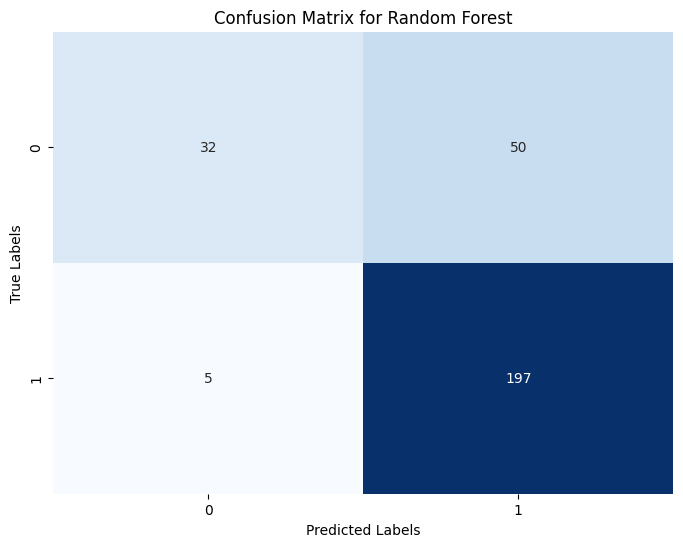


Random Forest Results:
Accuracy: 0.8063380281690141
F1 Score: 0.7794259333018944
Precision: 0.8170008121824281
Recall: 0.8063380281690141


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Models
models = {
    'XGBoost': XGBClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    confusion_mat = confusion_matrix(y_test, predictions)

    # Visualization of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Output
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


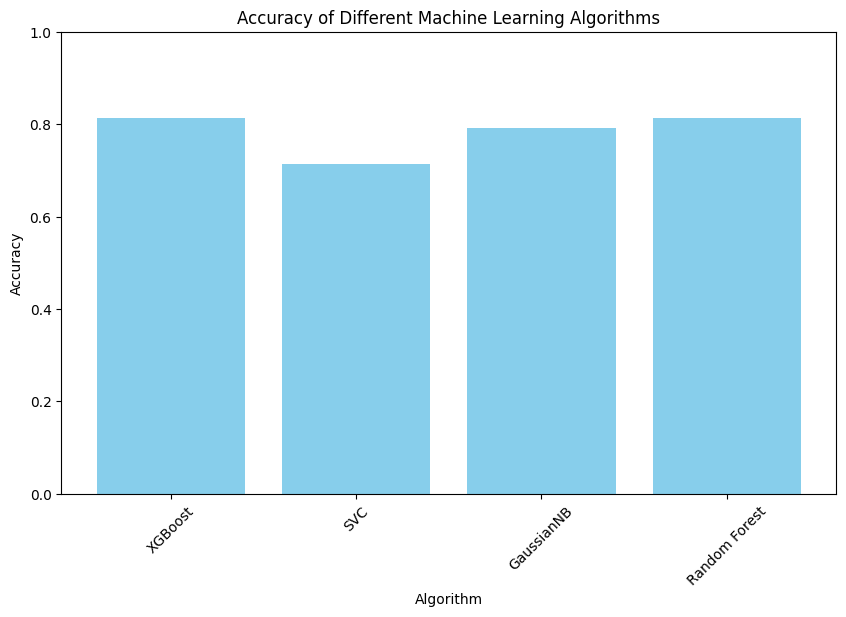

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store accuracy scores
accuracy_scores = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores[model_name] = accuracy

# Plotting the accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Machine Learning Algorithms')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Setting y-axis limit to ensure visibility of differences
plt.show()


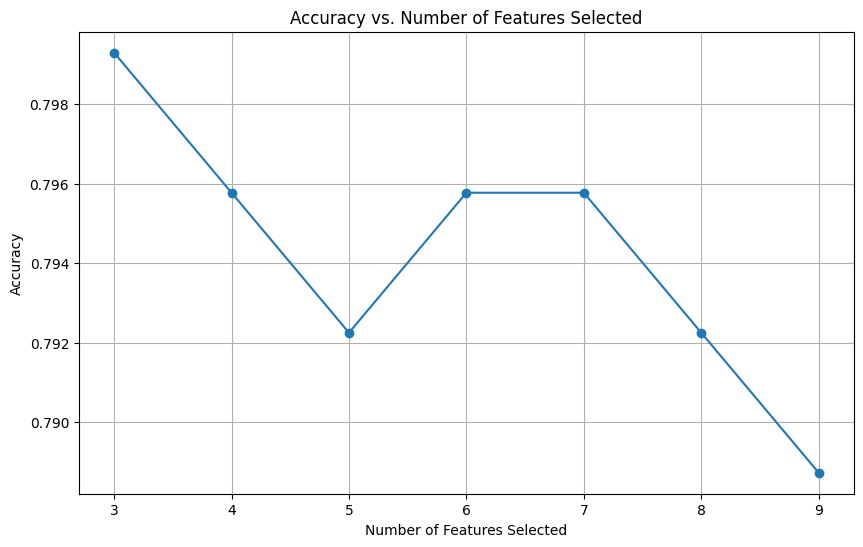

In [ ]:
# Visualize accuracy curve
def plot_accuracy_curve(results):
    num_features_selected = list(results.keys())
    accuracy_values = [result['accuracy'] for result in results.values()]

    plt.figure(figsize=(10, 6))
    plt.plot(num_features_selected, accuracy_values, marker='o', linestyle='-')
    plt.title('Accuracy vs. Number of Features Selected')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(num_features_selected)
    plt.show()

plot_accuracy_curve(results)

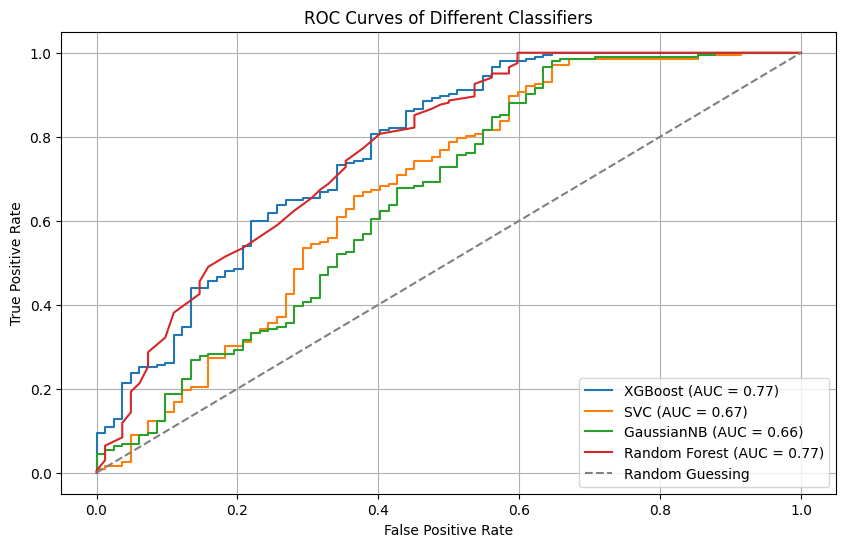

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Models
models = {
    'XGBoost': XGBClassifier(),
    'SVC': SVC(probability=True),  # Setting probability to True for calculating probabilities needed for ROC
    'GaussianNB': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
}

# Plot ROC curves for each classifier
plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):  # Check if the model has predict_proba method
        y_scores = model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class
    else:  # For SVC which doesn't have predict_proba method, use decision_function
        y_scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plotting random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Different Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


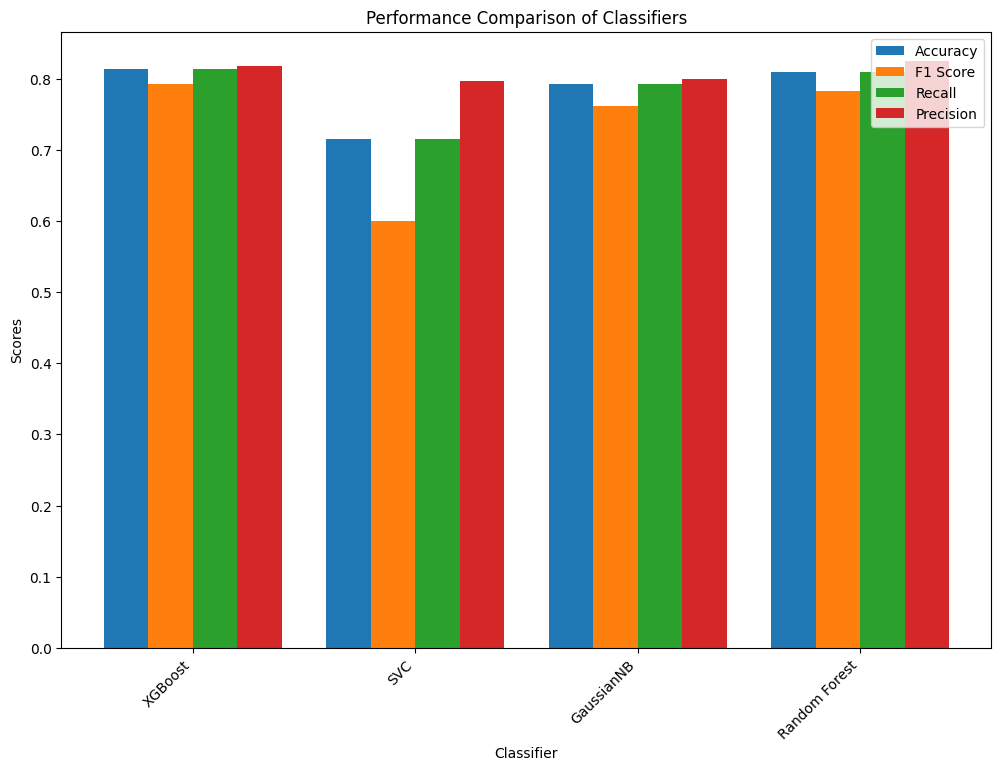

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Models
models = {
    'XGBoost': XGBClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    precision = precision_score(y_test, predictions, average='weighted')
    results[model_name] = {'accuracy': accuracy, 'f1_score': f1, 'recall': recall, 'precision': precision}

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
labels = list(results.keys())
accuracy_values = [result['accuracy'] for result in results.values()]
f1_values = [result['f1_score'] for result in results.values()]
recall_values = [result['recall'] for result in results.values()]
precision_values = [result['precision'] for result in results.values()]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

rects1 = ax.bar(x - 3*width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x - width/2, f1_values, width, label='F1 Score')
rects3 = ax.bar(x + width/2, recall_values, width, label='Recall')
rects4 = ax.bar(x + 3*width/2, precision_values, width, label='Precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classifier')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

plt.show()



XGBoost Results:
Accuracy: 0.8133802816901409
F1 Score: 0.7924822433472164
Precision: 0.8172364302577018
Recall: 0.8133802816901409
Confusion Matrix:
[[ 36  46]
 [  7 195]]


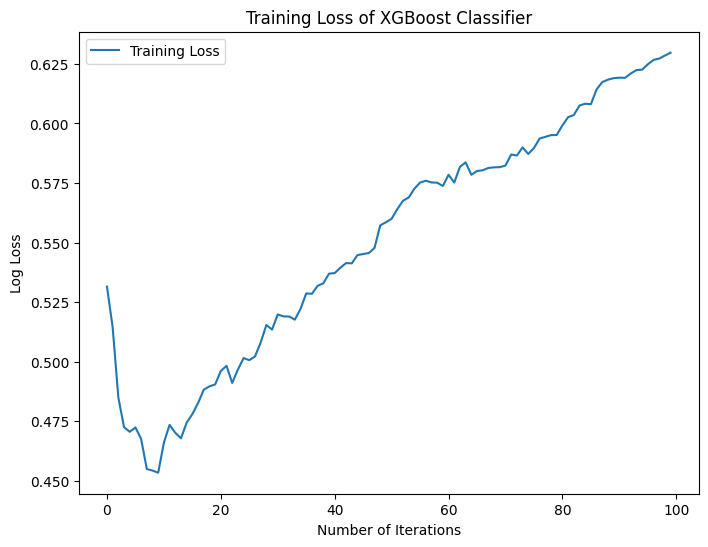


SVC Results:
Accuracy: 0.7147887323943662
F1 Score: 0.5994359899303909
Precision: 0.7964216393768975
Recall: 0.7147887323943662
Confusion Matrix:
[[  1  81]
 [  0 202]]

GaussianNB Results:
Accuracy: 0.7922535211267606
F1 Score: 0.761351591650458
Precision: 0.7991087084757541
Recall: 0.7922535211267606
Confusion Matrix:
[[ 29  53]
 [  6 196]]

Random Forest Results:
Accuracy: 0.8204225352112676
F1 Score: 0.793710697867345
Precision: 0.8435326820359911
Recall: 0.8204225352112676
Confusion Matrix:
[[ 33  49]
 [  2 200]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Models
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss'),  # Set eval_metric to 'logloss' to monitor log loss
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
}

# Train and evaluate each model
for model_name, model in models.items():
    if model_name == 'XGBoost':  # For XGBoost, set eval_metric in constructor
        model.set_params(eval_metric='logloss')
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    confusion_mat = confusion_matrix(y_test, predictions)

    # Output
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{confusion_mat}")

    # For XGBoost, plot the training loss
    if model_name == 'XGBoost':
        results = model.evals_result()
        train_errors = results['validation_0']['logloss']
        plt.figure(figsize=(8, 6))
        plt.plot(train_errors, label='Training Loss')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Log Loss')
        plt.title('Training Loss of XGBoost Classifier')
        plt.legend()
        plt.show()


In [ ]:
X_train_np = np.array(X_train)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from lime import lime_tabular
import librosa
from librosa.feature import zero_crossing_rate
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fftpack import fft

# Define the function to create training data
def create_training_data():
    training_data = []
    DATADIR = '/content/drive/MyDrive/fan/id_00'
    CATEGORIES = ['abnormal', 'normal']
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for audio in os.listdir(path):
            audio_path = os.path.join(path, audio)
            audio_array, sr_array = librosa.load(audio_path, duration=30)  # Load audio

            # Extract time domain features
            mean = np.mean(audio_array)
            median = np.median(audio_array)
            variance = np.var(audio_array)
            std_dev = np.std(audio_array)
            skewness = skew(audio_array)
            kurt = kurtosis(audio_array)
            zero_cross_rate = np.mean(zero_crossing_rate(audio_array))

            # Additional features
            peaks, _ = find_peaks(audio_array)
            num_waves = len(peaks)
            wave_duration = len(audio_array) / (num_waves + 1)  # Assuming one wave between each peak

            # Estimate pitch using harmonic and pitch_tuning functions
            harmonic, percussive = librosa.effects.hpss(audio_array)
            pitches, magnitudes = librosa.core.piptrack(y=harmonic, sr=sr_array)
            pitches = pitches[magnitudes > np.median(magnitudes)]

            if len(pitches) > 0:
                inst_freq = np.mean(librosa.hz_to_midi(pitches))
            else:
                inst_freq = 0.0  # Default value if no pitch is detected

            hjorth_params = librosa.feature.mfcc(y=audio_array, sr=sr_array, n_mfcc=13)
            mobility = np.mean(hjorth_params[1, :]) / np.mean(hjorth_params[0, :])
            activity = np.mean(hjorth_params[1, :])
            complexity = np.mean(hjorth_params[2, :])

            k_complex = np.sum(np.abs(np.diff(audio_array)) > 0.5)  # Example threshold

            energy = np.sum(audio_array**2)

            # Extract frequency domain features
            fft_result = fft(audio_array)
            freq_domain = np.abs(fft_result[:len(fft_result)//2])

            mean_freq = np.mean(freq_domain)
            median_freq = np.median(freq_domain)
            variance_freq = np.var(freq_domain)
            std_dev_freq = np.std(freq_domain)
            skewness_freq = skew(freq_domain)
            kurt_freq = kurtosis(freq_domain)

            # Additional frequency domain features
            delta = np.sum(freq_domain[(0 <= freq_domain) & (freq_domain <= 4)])
            theta = np.sum(freq_domain[(4 < freq_domain) & (freq_domain <= 8)])
            alpha = np.sum(freq_domain[(8 < freq_domain) & (freq_domain <= 13)])
            beta = np.sum(freq_domain[(13 < freq_domain) & (freq_domain <= 30)])
            gamma = np.sum(freq_domain[(30 < freq_domain) & (freq_domain <= 40)])
            sigma = np.sum(freq_domain[(40 < freq_domain) & (freq_domain <= 50)])

            zero_a = np.sum(freq_domain[(0 < freq_domain) & (freq_domain <= alpha)])
            b_a = np.sum(freq_domain[(beta < freq_domain) & (freq_domain <= alpha)])

            features = [mean, median, variance, std_dev, skewness, kurt,
                        zero_cross_rate, num_waves, wave_duration, inst_freq,
                        mobility, activity, complexity, k_complex, energy,
                        mean_freq, median_freq, variance_freq, std_dev_freq, skewness_freq, kurt_freq,
                        delta, theta, alpha, beta, gamma, sigma, zero_a, b_a]

            training_data.append([features, class_num])
    return training_data

# Call the function to create training data
training_data = create_training_data()

# Split data into features (X) and labels (y)
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model with increased max_iter
classifier = LogisticRegression(random_state=0, max_iter=1000)
classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred = classifier.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# LIME explanation
feature_names = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurt', 'zero_cross_rate',
                 'num_waves', 'wave_duration', 'inst_freq', 'mobility', 'activity', 'complexity',
                 'k_complex', 'energy', 'mean_freq', 'median_freq', 'variance_freq', 'std_dev_freq',
                 'skewness_freq', 'kurt_freq', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'sigma',
                 'zero_a', 'b_a']
explainer = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=feature_names, class_names=['abnormal', 'normal'])

# Example explanation for the first test instance
explanation = explainer.explain_instance(X_test_scaled[0], classifier.predict_proba, num_features=10)
explanation.show_in_notebook()


Accuracy: 0.795774647887324
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.32      0.47        82
           1       0.78      0.99      0.87       202

    accuracy                           0.80       284
   macro avg       0.85      0.65      0.67       284
weighted avg       0.82      0.80      0.76       284



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from lime import lime_tabular
import librosa
from librosa.feature import zero_crossing_rate
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fftpack import fft

In [ ]:
# Split data into features (X) and labels (y)
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Support Vector Classifier (SVC) model
svc_classifier = SVC()
svc_classifier.fit(X_train_scaled, y_train)

# Train the Random Forest Classifier model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)

# Train the XGBoost Classifier model
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svc = svc_classifier.predict(X_test_scaled)
y_pred_rf = rf_classifier.predict(X_test_scaled)
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Evaluate performance
print("Support Vector Classifier (SVC) Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Classifier Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Additional performance metrics
print("\nSupport Vector Classifier (SVC) Classification Report:\n", classification_report(y_test, y_pred_svc))
print("\nRandom Forest Classifier Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nXGBoost Classifier Classification Report:\n", classification_report(y_test, y_pred_xgb))

# LIME explanation
explainer = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=['feature'+str(i) for i in range(X_train_scaled.shape[1])], class_names=['abnormal', 'normal'])



# Example explanation for the first test instance for Random Forest
explanation_rf = explainer.explain_instance(X_test_scaled[0], rf_classifier.predict_proba, num_features=10)
explanation_rf.show_in_notebook()

# Example explanation for the first test instance for XGBoost
explanation_xgb = explainer.explain_instance(X_test_scaled[0], xgb_classifier.predict_proba, num_features=10)
explanation_xgb.show_in_notebook()

Support Vector Classifier (SVC) Accuracy: 0.7992957746478874
Random Forest Classifier Accuracy: 0.8274647887323944
XGBoost Classifier Accuracy: 0.8063380281690141

Support Vector Classifier (SVC) Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.30      0.47        82
           1       0.78      1.00      0.88       202

    accuracy                           0.80       284
   macro avg       0.89      0.65      0.67       284
weighted avg       0.84      0.80      0.76       284


Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.43      0.59        82
           1       0.81      0.99      0.89       202

    accuracy                           0.83       284
   macro avg       0.88      0.71      0.74       284
weighted avg       0.85      0.83      0.80       284


XGBoost Classifier Classification Report:
               precision    recal

In [ ]:
# Initialize and train the SVC classifier with probability=True
svc_classifier = SVC(probability=True)
svc_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svc = svc_classifier.predict(X_test_scaled)

# Evaluate performance
print("Support Vector Classifier (SVC) Accuracy:", accuracy_score(y_test, y_pred_svc))

# Additional performance metrics
print("\nSupport Vector Classifier (SVC) Classification Report:\n", classification_report(y_test, y_pred_svc))

# LIME explanation for SVC
explanation_svc = explainer.explain_instance(X_test_scaled[0], svc_classifier.predict_proba, num_features=10)
explanation_svc.show_in_notebook()


Support Vector Classifier (SVC) Accuracy: 0.7992957746478874

Support Vector Classifier (SVC) Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.30      0.47        82
           1       0.78      1.00      0.88       202

    accuracy                           0.80       284
   macro avg       0.89      0.65      0.67       284
weighted avg       0.84      0.80      0.76       284

